# Szybka Transformacja Fouriera FFT

Celem niniejszego projektu było zaprojektowanie oraz zaimplementowanie algorytmu szybkiej transformacji Fouriera (FFT – Fast Fourier Transform) w układzie FPGA oraz opracowanie zewnętrznego oprogramowania umożliwiającego praktyczne wykorzystanie koprocesora i demonstrację poprawności jego działania. Do realizacji projektu wykorzystano Vivado 2022.1, Pycharm, Python. 3.9, platforma PYNQ oraz płytkę Kria KV260.

Transformacja Fouriera jest jedną z podstawowych transformacji matematycznych. Używana jest ona szczególnie często w technice, gdzie służy do analizy oraz syntezy sygnałów dźwiękowych, telekomunikacyjnych lub obrazów.

Wykonanie projektu rozpoczęto od teoretycznej analizy zagadnienia. Początkowo algorytm zaimplementowano w języku Matlab oraz Python, a następnie przeniesiono go do języka Verilog, gdzie wykonano pierwsze symulacje działania. W pierwszej wersji algorytm zrealizowany był całkowicie sekwencyjnie, tj. dane były przetwarzane po kolei przez każdy krok algorytmu. Następnie program został podzielony na funkcjonalne moduły, co znacznie zwiększyło elastyczność i umożliwiło stworzenie kolejnej wersji projektu. Wersja ta zakładała równoległe wykonywanie kolejnych (opisanych szczegółowo w późniejszych sekcjach dokumentu) kroków, co skutkowało istotnym zwiększeniem wydajności algorytmu. Ze względu na blokową naturę FFT ułatwiona była także dalsza rozbudowa o swoistą potokowość, która umożliwiła dodatkowe zwiększenie szybkości.


# Opis teoretyczny algorytmu
## Transformacja Fouriera

Transformacja Fouriera (FT – Fourier Transform), w ujęciu technicznym, jest operacją pozwalającą na przekształcenie dowolnych danych w funkcji czasu na odpowiadające dane w funkcji częstotliwości, tj. na obliczenie widma danego sygnału wejściowego. Zarówno dane wejściowe, jak i wyjściowe, są liczbami zespolonymi, dzięki czemu możliwa jest reprezentacja zależności fazowych w sygnale. Sama transformacja Fouriera operuje na danych ciągłych, stąd jest nierealizowalna w oprogramowaniu. Istnieje natomiast jej odpowiednik operujący na policzalnym zbiorze danych, zwany dyskretną transformacją Fouriera (DFT – Discrete Fourier Transform). Algorytm DFT jest niemalże identyczny, jak ten dla FT, z tym że operuje na dyskretnych danych oraz współczynnikach. Jego zaletą jest możliwość obliczenia transformaty dla zbioru danych o dowolnej wielkości, niemniej będąc algorytmem wymagającym czasowo: jego złożoność obliczeniowa jest proporcjonalna do kwadratu ilości danych (O(n2)), co wiąże się z ogromnymi czasami obliczeń dla dużych zbiorów, niejednokrotnie zbyt dużymi do praktycznego zastosowania.

## Szybka transformacja Fouriera

Przy pewnych założeniach co do ilości danych problem dużej złożoności obliczeniowej jest jednak rozwiązywalny. Algorytm Cooleya-Tukeya polega na rozbiciu DFT o długości N na N1 transformacji o długości N2. Algorytm ten można zastosować rekurencyjnie, ostatecznie dochodząc do trywialnego DFT o długości 1. Szczególnym przypadkiem tego algorytmu jest rekursywny podział DFT o długości N na dwa DFT o długości N/2. Takie wyrażenie algorytmu nazywane jest lematem Danielsona-Lanczosa. W ogólności, na mocy lematu Danielsona-Lanczosa, DFT można obliczyć jako sumę dwóch DFT po elementach parzystych oraz nieparzystych wraz z odpowiednim współczynnikiem:
<center>
<img src="./images/wzor.png" width="300"/>
</center>
gdzie X_n oraz x_n to, odpowiednio, elementy wektora wyjściowego i wejściowego, a W_N^n=e^((-j2πn)/N) jest współczynnikiem zwanym z ang. twiddle factor. Jeśli założymy, że dane wejściowe mają długość równą N=2^r, a r jest liczbą naturalną większą od zera, to takie DFT może zostać łatwo obliczone poprzez rekurencyjny podział i przeplot mniejszych transformacji.

Algorytm Cooleya-Tukeya, dla N będącego potęgą liczby 2, można zaprezentować za pomocą tzw. diagramu motylkowego. Diagram taki, dla N=8, przedstawiono na rysunku.

<center>
<img src="./images/butterfly.png" width="300"/>
</center>
 
Trzeba zauważyć, że indeksy elementów wejściowych są w nietypowej kolejności. Kolejność tę uzyskuje się przez odwrócenie bitów indeksów. Odwrócenie bitów indeksów wejściowych nazywane jest decymacją w czasie (DIT – decimation-in-time) i jest najczęściej spotykanym rozwiązaniem, choć możliwa jest również decymacja w częstotliwości (DIF – decimation-in-frequency). Operacja odwrócenia bitów jest konieczna dla zbudowania diagramu motylkowego i efektywnego obliczenia DFT. Analizując podany wcześniej wzór dla kolejnych kroków algorytmu można zauważyć, że do obliczenia każdego kolejnego kroku wykorzystywane są jedynie wyniki poprzednich kroków oraz współczynniki twiddle factor i nie jest konieczne obliczenie wartości eksponencjalnych czynników widocznych we wzorze. Ciekawą właściwością opisywanego algorytmu jest możliwość obliczeń w miejscu (ang. in place, łac. in situ), tj. użycie pamięci niezależne od długości danych, a także znacznie zmniejszona złożoność obliczeniowa (O(N*log2(N)). Dzięki temu algorytm ten jest jednym z przykładów szybkiej transformacji Fouriera (FFT – Fast Fourier Transform).
Na diagramie można zauważyć, że w każdym etapie (stage) wykorzystywana jest taka sama liczba motylków (przecinających się linii) równa N/2, a liczba etapów jest zawsze równa log2(N). Ponadto wszystkie motylki w danym etapie korzystają z innych danych i nie wpływają na siebie wzajemnie. Tym samym algorytm ten dobrze nadaje się do implementacji w układach FPGA, po pierwsze umożliwiając równoległe wykonywanie obliczeń przez wszystkie motylki, a po drugie naturalnie dzieląc algorytm na kroki, umożliwiając zastosowanie struktury typu pipeline.




# Projekt Verilog
Pierwsza wersja algorytmu zakładała sekwencyjne wejście danych, a następnie wykonywanie pojedynczo każdej z operacji motylka. Algorytm poruszał się zgodnie z maszyną stanów przedstawioną na wrysunku poniżej.
<center>
<img src="./images/fsm.png" style="height: 500px;"/>
</center>
Opis maszyny stanów:

- ILDE – oczekiwanie na zewnętrzny sygnał startu
- CLOCKING_IN – stan odpowiedzialny za pobieranie danych wejściowych i ustawianie ich w odpowiedniej kolejności w buforze. Dane pobierane są z wejścia modułu z każdym taktem zegara, aż do momentu pobrania odpowiedniej liczby danych określonych przez parametr FFT_SIZE.
- CALCULATING – stan, w którym obliczane jest FFT z danych wejściowych.
- CLOCKING_OUT – stan odpowiedzialny za wysyłanie danych do wyjścia. Kolejne dane wysyłane są wraz z każdym cyklem zegara.

Ważnym elementem utworzonego algorytmu jest jego responsywność, która umożliwia dostosować rozmiar obliczanego FFT poprzez ustawienie parametru FFT_SIZE.

Kolejna wersja algorytmu zakłada zwiększenie szybkości poprzedniej wersji. Z racji, że w każdym kolejnym stopniu FFT wykonywana jest ta sama ilość operacji motylkowych, zdecydowano się je zrównoleglić. W tym celu w module fft.v tworzone jest kilka instancji modułu butterfly.v. Ilość tworzonych motylków zależy od rozmiaru FFT, a dokładnie od log2(Rozmiar FFT). Wykorzystane moduły oraz maszyna stanów zaczerpnięta została z pierwszej wersji algorytm

Trzecią wersją był algorytm, który pomijał maszynę stanów oraz zakładał, że wszystkie dane podawane są jednocześnie na wejście modułu. Następnie wykonywał on operacje odwracania bitów indeksów danych wejściowych. Kolejnym krokiem było stworzenie log2(Rozmiar_FFT) stopni FFT, które wykonywane były jeden po drugim. W każdym stopniu tworzona była odpowiednia ilość instancji motylków, a następnie przydzielono każdej z instancji odpowiednie dane wejściowe. Po wykonaniu każdego stopnia otrzymane dane przekazywane był do kolejnych stopni. Ostatni stopień przekazywał dane na wyjście modułu. Algorytm również napisany został w sposób responsywny dla różnej wartości FFT.

Każda z wersji algorytmu przechodziła poprawnie tworzone symulacje oraz syntezę. W algorytmach wykorzystywane są liczby 24-bitowe, gdzie 14 bitów to część całkowita natomiast 10 bitów przeznaczono na cześć ułamkową.

Ostateczna, czwarta wersja projektu to zmodyfikowany algorytm z wersji 2 rozwinięty o działanie potokowe. Zbudowaną maszynę stanu rozdzielono na 3 osobne moduły: clocking in, calculating, clocking out. Pozwalały one odpowiednio pobierać dane, obliczać FFT oraz wysłać dane wynikowe. Główną cechą jest to, że każdy z modułów pracuje niezależnie, więc możliwe jest wykonywanie równocześnie odpowiednich etapów dla 3 kolejnych zestawów danych. Z racji, że układ obliczający trwa najwięcej cykli zegara, więc to on wymusza czas trwania pozostałych układów. Układ pobierający dane wejściowe zapisuje dane z każdym cyklem zegara, aż do momentu zebrania 8 próbek (rozmiar FFT). Następnie oczekuje na sygnał gotowości do pobrania nowych danych przez układ obliczający. Po takim sygnale przekazuje zebrane dane i zaczyna ponownie pobierać kolejny zestaw próbek. Moduł obliczający po odbiorze zestawu nowych danych oblicza FFT, a po zakończeniu obliczeń przekazuje wynik do układu wysyłającego. Ostatni moduł po otrzymaniu wyniku z poprzedniego bloku, wystawia z każdym cyklem zegara pojedynczo każdą z liczb wynikowych na wyjście całego układu FFT. Po wystawieniu wszystkich liczb (8) ponownie oczekuje na dane z układu obliczającego. Na rysunku poniżej przedstawiono schemat blokowy działania całego modułu FFT wraz ze wszystkimi sygnałami wejściowym i wyjściowymi dla magistrali AXI Stream. Projekt skonfigurowano dla FFT o rozmiarze 8 oraz danych 16 bitowych (format 10:6).
<center>
<img src="./images/pipeline_schemat.png" style="height: 500px;" />
</center>

In [47]:
#IMPORTANT IMPORT
from pynq import Overlay
from pynq import allocate

import numpy as np
import time
import math
import matplotlib.pyplot as plt

# Implementacje wykorzystujące AXI - Lite

Ostatnim etapem projektu było przetestowanie stworzonych algorytmów ze sprzętem. W tym celu stworzone algorytmy zamknięto w osobne układy IP-Core, a następnie połączono z procesorem przy użyci magistrali AXI-Lite. Przykładowy diagram blokowy dla jednego z algorytmów przedstawiono poniżej.
<center>
<img src="./images/block_diagram_1.png" width="800"/>
</center>

Mimo responsywności stworzonych algorytmów, aby wygenerować bitstream należało wcześniej zdecydować się na rozmiar FFT. Dla wszystkich 3 algorytmów zdecydowano się ustawić rozmiar FFT na 8. W algorytmach wykorzystujących maszynę stanów, dane wprowadzane są sekwencyjnie jedna po drugiej, więc przy tworzeniu IP Cora wykorzystano 2 rejestry danych wejściowych (część rzeczywista i urojona), 2 rejestry danych wyjściowych oraz rejestry sygnalizacyjne. Natomiast dla trzeciej wersji projektu, która wymagała wprowadzenia jednocześnie wszystkich danych, wykorzystano 16 rejestrów danych wejściowych (8 liczb część rzeczywista oraz 8 liczb część urojona) oraz 16 rejestrów danych wyjściowych i rejestry sygnalizacyjne. Dla algorytmów 1 i 2 istnieje możliwość wygenerowania kolejnego bitstreamu z ustawionym większym rozmiarem FFT. Dla algorytmu 3 uzyskanie wersji dla większego rozmiaru FFT jest bardziej skomplikowane i zmusza do wykorzystania większej ilości rejestrów.

Poniżej zaimplementowano stworzoną wcześniej funkcję wzorcową w Pythonie, a następnie utworzony został generator losowych próbek. W dalszej części notatnika tworzono overlay dla każdej wersji algorytmu oraz obliczano FFT dla tych samych danych wejściowych i porównywano z wynikiem funkcji wzorcowej. Błędy obliczeniowe dla każdej z próbek w danej implementacji algorytmu przedstawiane są na wykresie. Dodatkowo obliczana została średnia kwadratowa błędu RMSE (ang. Root Mean Square Error) wyrażana wzorem: 
<center>
<img src="./images/wzor2.png" width="300"/>
</center>
gdzie:

- X – obliczona wartość próbki przez układ FPGA,
- Z – obliczona wartość próbki przez funkcje wzorcową,
- N – rozmiar FFT.


In [48]:
#Sample function

def fft_sample(x):
    N = len(x)
    if N == 1:
        return [x[0]]
    X = [0] * N
    even = fft_sample(x[:N:2])
    odd = fft_sample(x[1:N:2])
    for k in range(N // 2):
        w = math.e ** (-2j * math.pi * k / N)
        X[k] = even[k] + w * odd[k]
        X[k + N // 2] = even[k] - w * odd[k]
    return X

In [49]:
# Sample generator
N = 8
FXP = 1024
data_real = np.array([])
data_imag = np.array([])
data_complex = np.array([])

for i in range (N):
    data_real = np.append(data_real,np.random.rand())
    data_imag = np.append(data_imag,np.random.rand())

data_complex = data_real + 1j*data_imag    


#Convert data to data fixed-point 14:10
for i in range (N):
    data_real[i] =  int(data_real[i]*FXP)
    data_imag[i] =  int(data_imag[i]*FXP)
  

In [50]:
## Overlay for FFT Version 1 (with one butterfly)
fft_ov = Overlay("fft_seq_wrapper.xsa")
fft_seq = fft_ov.fft_seq_ip_0.mmio

In [51]:
# FFT Implementation on FPGA (with one butterfly)

N_size = 8
start_offset = 8
data_en_offset = 12
ready_offset = 16
in_R_offset = 20
in_I_offset = 24
out_R_offset = 28
out_I_offset = 32


def convert_for_signed_24bit(number):
    if number >= 0x800000:
        return number - 0x1000000
    else:
        return number

def fft_sequential(in_r, in_i):
    out_r = np.array([])
    out_i = np.array([])
    
    fft_seq.write(start_offset,1)    
    
    for i in range(N_size):
        fft_seq.write(data_en_offset,0)
        fft_seq.write(in_R_offset,int(in_r[i]))
        fft_seq.write(in_I_offset,int(in_i[i]))
        fft_seq.write(data_en_offset,1)
        
    fft_seq.write(data_en_offset,0) 
    while (fft_seq.read(ready_offset) == 0):
        pass
     
    for i in range(N_size):
        fft_seq.write(data_en_offset,1)
        out_r = np.append(out_r, fft_seq.read(out_R_offset))
        out_i = np.append(out_i, fft_seq.read(out_I_offset))
        fft_seq.write(data_en_offset,0)
    for i in range(N_size):
        out_r[i] = convert_for_signed_24bit(out_r[i])
        out_i[i] = convert_for_signed_24bit(out_i[i])
    fft_seq.write(start_offset,0)
    return (out_r, out_i)

RMSE: 0.002505764784762


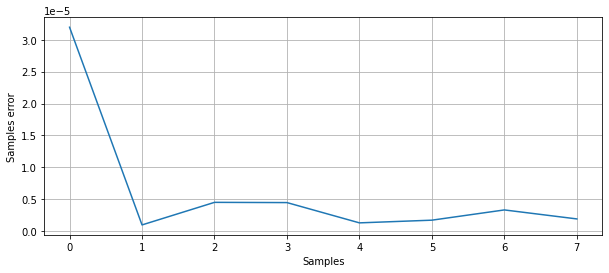

In [52]:
#Implementation comparison -> Sample function vs FFT Implementation on FPGA (with one butterfly)

#Compute FFT using sample function
X_sample = fft_sample(data_complex)

#Compute FFT using FFT Implementation on FPGA (with one butterfly)
X_fpga_r_seq , X_fpga_i_seq = fft_sequential(data_real, data_imag)

X_fpga_complex_seq = np.array([])
X_fpga_complex_seq = X_fpga_r_seq + 1j*X_fpga_i_seq
X_fpga_complex_seq = X_fpga_complex_seq/FXP

# Error between sample implementation and fpga implementation
X_err_seq = np.abs(X_fpga_complex_seq - X_sample)**2
# RMSE
X_RMSE_seq = np.sqrt(np.mean(X_err_seq))
print('RMSE:', np.round(X_RMSE_seq, 15))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
ax.plot(X_err_seq)
ax.set_ylabel('Samples error')
ax.set_xlabel('Samples')
plt.grid()
plt.show()

In [53]:
## Overlay for FFT Version 2 (with parallel butterflies)
fft_ov = Overlay("fft_parallel_wrapper.xsa")
fft_parallel = fft_ov.fft_parallel_ip_0.mmio

In [54]:
# FFT Implementation on FPGA (with parallel butterflies)

N_size = 8
start_offset = 8
data_en_offset = 12
ready_offset = 16
in_R_offset = 20
in_I_offset = 24
out_R_offset = 28
out_I_offset = 32


def convert_for_signed_24bit(number):
    if number >= 0x800000:
        return number - 0x1000000
    else:
        return number

def fft_parall(in_r, in_i):
    out_r = np.array([])
    out_i = np.array([])
    
    fft_parallel.write(start_offset,1)    
    
    for i in range(N_size):
        fft_parallel.write(data_en_offset,0)
        fft_parallel.write(in_R_offset,int(in_r[i]))
        fft_parallel.write(in_I_offset,int(in_i[i]))
        fft_parallel.write(data_en_offset,1)
    
    fft_parallel.write(data_en_offset,0)    
    while (fft_parallel.read(ready_offset) == 0):
        pass
    
    for i in range(N_size):
        fft_parallel.write(data_en_offset,1)
        out_r = np.append(out_r, fft_parallel.read(out_R_offset))
        out_i = np.append(out_i, fft_parallel.read(out_I_offset))
        fft_parallel.write(data_en_offset,0)
    for i in range(N_size):
        out_r[i] = convert_for_signed_24bit(out_r[i])
        out_i[i] = convert_for_signed_24bit(out_i[i])
    fft_parallel.write(start_offset,0)
    return (out_r, out_i)

RMSE: 0.002505764784762


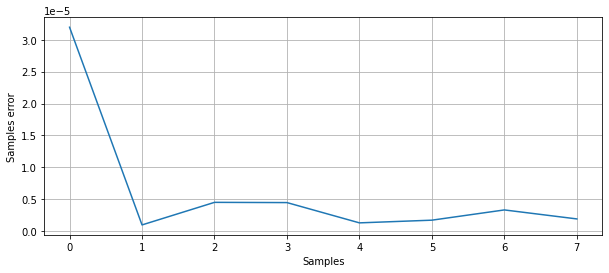

In [55]:
#Implementation comparison -> Sample function vs FFT Implementation on FPGA (with parallel butterflies)

#Compute FFT using sample function
X_sample = fft_sample(data_complex)

#Compute FFT using FFT Implementation on FPGA (with parallel butterflies)
X_fpga_r_parallel , X_fpga_i_parallel = fft_parall(data_real, data_imag)

X_fpga_complex_parallel = np.array([])
X_fpga_complex_parallel = X_fpga_r_parallel + 1j*X_fpga_i_parallel
X_fpga_complex_parallel = X_fpga_complex_parallel/FXP

# Error between sample implementation and fpga implementation
X_err_parallel = np.abs(X_fpga_complex_parallel - X_sample)**2
# RMSE
X_RMSE_parallel = np.sqrt(np.mean(X_err_parallel))
print('RMSE:', np.round(X_RMSE_parallel, 15))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
ax.plot(X_err_parallel)
ax.set_ylabel('Samples error')
ax.set_xlabel('Samples')
plt.grid()
plt.show()

In [56]:
## Overlay for FFT Version 3 (divided into stages)
fft_ov = Overlay("fft_divided_stage_wrapper.xsa")
fft_stages = fft_ov.fft_pipe_N8_0.mmio

In [57]:
# FFT Implementation on FPGA (divided into stages)
N_size = 8
start_offset = 0
ready_offset = 132
in_buffer_offset = [x*4 for x in range(1,17)]
out_buffer_offset = [x*4 for x in range(17,33)]

def convert_for_signed_24bit(number):
    if number >= 0x800000:
        return number - 0x1000000
    else:
        return number

def fft_divided_into_stages(in_r, in_i):
    out_r = np.array([])
    out_i = np.array([])
    fft_stages.write(start_offset,0)
    for i in range(N_size):
        fft_stages.write(in_buffer_offset[i],int(in_r[i]))
        fft_stages.write(in_buffer_offset[i+N_size],int(in_i[i]))
    
    fft_stages.write(start_offset,1)
    while (fft_stages.read(ready_offset) == 0):
        pass 
    for i in range(N_size):
        out_r = np.append(out_r, fft_stages.read(out_buffer_offset[i]))
        out_i = np.append(out_i, fft_stages.read(out_buffer_offset[i+N_size]))
    for i in range(N_size):
        out_r[i] = convert_for_signed_24bit(out_r[i])
        out_i[i] = convert_for_signed_24bit(out_i[i])
    
    return (out_r, out_i)
    

RMSE: 0.002505764784762


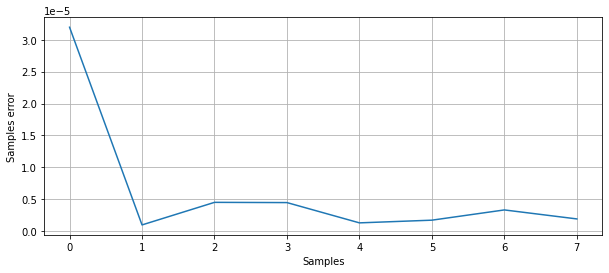

In [59]:
#Implementation comparison -> Sample function vs FFT Implementation on FPGA (divided into stages)

#Compute FFT using sample function
X_sample = fft_sample(data_complex)

#Compute FFT using FFT Implementation on FPGA (divided into stages)
X_fpga_r_stages , X_fpga_i_stages = fft_divided_into_stages(data_real, data_imag)

X_fpga_complex_stages = np.array([])
X_fpga_complex_stages = X_fpga_r_stages + 1j*X_fpga_i_stages
X_fpga_complex_stages = X_fpga_complex_stages/FXP

# Error between sample implementation and fpga implementation
X_err_stages = np.abs(X_fpga_complex_stages - X_sample)**2
# RMSE
X_RMSE_stages = np.sqrt(np.mean(X_err_stages))
print('RMSE:', np.round(X_RMSE_stages, 15))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
ax.plot(X_err_stages)
ax.set_ylabel('Samples error')
ax.set_xlabel('Samples')
plt.grid()
plt.show()

In [60]:
#Implementation comparison
print('RMSE FFT Version 1 (with one butterfly):', np.round(X_RMSE_seq, 15))
print('RMSE FFT Version 2 (with parallel butterflies):', np.round(X_RMSE_parallel, 15))
print('RMSE FFT Version 3 (divided into stages):', np.round(X_RMSE_stages, 15))

RMSE FFT Version 1 (with one butterfly): 0.002505764784762
RMSE FFT Version 2 (with parallel butterflies): 0.002505764784762
RMSE FFT Version 3 (divided into stages): 0.002505764784762


# Implementacja wykorzystujaca AXI - Stream
Dla ostatniej wersji projektu wykorzystującej potokowość wykorzystano magistralę AXI Stream oraz układ DMA. Schemat blokowy przedstawiono poniżej.
<center>
<img src="./images/block_diagram_2.png" width="800"/>
</center>
Z racji, że dane nie były pobierane z DMA z każdym cyklem zegara należało odpowiednio ustawiać sygnały tvalid i tready na magistrali AXIS. W celu poprawnej implementacji należało bardzo dokładnie przeanalizować dokumentację producenta w celu zrozumienia zasady działania wszystkich sygnałów sterujących tvalid, tready i tlast. Złe ustawianie/kasowanie wymienionych sygnałów spowodowało wiele komplikacji przy uruchomianiu projektu na sprzęcie, pomimo że wyniki symulacji w testbenchu były poprawne.


Na rysunku poniżej przedstawiono przebieg pokazujący potokowe działanie układu. Na przebiegu widać, że po odebraniu pierwszych 8 danych wejściowych ustawiany jest sygnał fft_start i jeśli sygnał fft_ready również jest w stanie wysokim moduł odbierający dane przekazuje je do układu obliczającego kasując przy tym sygnał fft_start i fft_ready. Następnie pobiera kolejne próbki i oczekuje na sygnał fft_ready oznaczający, że FFT zostało obliczone i można przekazać dane. W momencie, gdy układ obliczający skończy pracę przekazuje sygnał fft_ready jako sygnał clocker_start oznaczający, że moduł wysyłający wynik może pobrać dane do wysyłki. Po skończonej wysyłce układ clocking out wystawia sygnał clocker_ready oznaczający gotowość do pobrania nowych danych do wysyłki. Z przebiegu widać działanie potokowe układu. W momencie wysłania wyniku dla pierwszego zestawu danych pobierane są dane dla trzeciego zestawu, a drugi zestaw jest w tym czasie obliczany.
<center>
<img src="./images/potok.png" width="800"/>
</center>

W notatniku stworzono funkcję generującą zestaw losowych danych wejściowych. Liczba generowanych zestawów określona jest przez parametr N_packs, który można modyfikować. Umożliwia to wysłanie do układu FFT kilku paczek danych w celu wykorzystania zaimplementowanej potokowości. Wygenerowane dane trafiają do wcześniej alokowanego buforu wejściowego w odpowiednim formacie. Bufor składa się z liczb 32-bitowych. 16 starszych bitów każdej z liczb reprezentuje część urojoną próbki, natomiast 16 bitów młodszych reprezentuje część rzeczywistą.
Następnie gotowy bufor wejściowy wysyłany jest do DMA, a później wynik odbierany w buforze wyjściowym.
Końcowym etapem jest rozdzielenie wyniku na kilka zestawów w zależności od wcześniej ustawionego parametru N_packs i porównanie z wynikami funkcji wzorcowej.

W przypadku tego algorytmu można zauważyć wzrost błędu między próbkami niż w przypadku pozostałych wersji algorytmów. Spowodowane jest do zmniejszeniem liczby bitów reprezentujących cześć ułamkową z 10 bitów do 6 bitów. Zdecydowano się na redukcję, aby dopasować rozmiar wysyłanych danych do DMA.

In [61]:
# Sample generator for pipeline version FFT
N_pipeline = 8
N_packs = 3      # Number of data packs
FXP_pipeline = 64
data_real_pipeline = np.array([],dtype=np.int16)
data_imag_pipeline = np.array([],dtype=np.int16)
data_complex_pipeline = np.array([])

for i in range (N_packs*N_pipeline):
    data_real_pipeline = np.append(data_real_pipeline,np.random.rand())
    data_imag_pipeline = np.append(data_imag_pipeline,np.random.rand())

data_complex_pipeline = data_real_pipeline + 1j*data_imag_pipeline
#Convert data to data fixed-point 10:6
for i in range (N_packs*N_pipeline):
    data_real_pipeline[i] =  int(data_real_pipeline[i]*FXP_pipeline)
    data_imag_pipeline[i] =  int(data_imag_pipeline[i]*FXP_pipeline)

In [62]:
fft_ov = Overlay("fft.xsa")
fft_pipe = fft_ov.axi_dma_0

In [63]:
in_buffer = allocate(shape=(N_packs*N_pipeline,), dtype=np.uint32)
out_buffer = allocate(shape=(N_packs*N_pipeline,), dtype=np.uint32)
array1_uint32 = data_real_pipeline.astype(np.uint32)
array2_uint32 = data_imag_pipeline.astype(np.uint32)

for i in range(N_packs*N_pipeline):
    in_buffer[i] =(array2_uint32[i] << 16) | array1_uint32[i]

In [64]:
fft_pipe.sendchannel.transfer(in_buffer)
fft_pipe.recvchannel.transfer(out_buffer)

RMSE for data pack [ 1 ] : 0.044201470720234


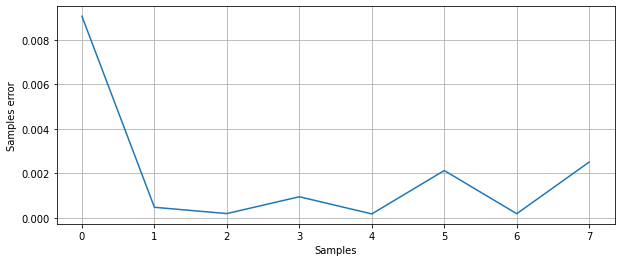

RMSE for data pack [ 2 ] : 0.04114987826273


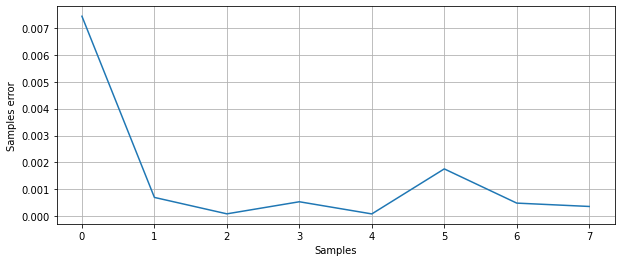

RMSE for data pack [ 3 ] : 0.041736284134556


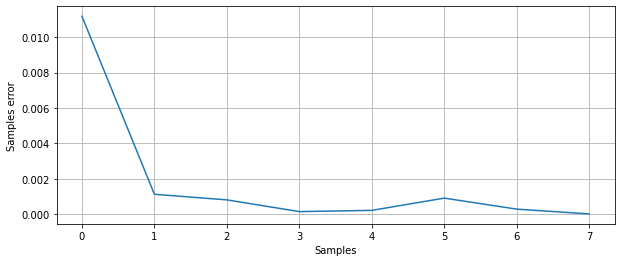

In [65]:
array1_out = np.array([],dtype=np.int16)
array2_out = np.array([],dtype=np.int16)
X_sample_pipeline = []
X_fpga_pipeline = []
X_err_pipeline = []
X_RMSE_pipeline = []

for i in range(N_packs*N_pipeline):
    array1_out = np.append(array1_out, (out_buffer[i] & 0x0000ffff).astype(np.int16))
    array2_out = np.append(array2_out, (out_buffer[i] >> 16).astype(np.int16))
    
array1_out =array1_out/FXP_pipeline
array2_out =array2_out/FXP_pipeline

X_pipe = array1_out + 1j*array2_out
for i in range(N_packs):
    X_fpga_pipeline.append(X_pipe[N_pipeline*i:N_pipeline*(i+1)])
for i in range(N_packs):
    X_sample_pipeline.append(fft_sample(data_complex_pipeline[N_pipeline*i:N_pipeline*(i+1)]))

for i in range(N_packs):    
    X_err_pipeline.append(np.abs(X_fpga_pipeline[i] - X_sample_pipeline[i])**2)
    X_RMSE_pipeline.append(np.sqrt(np.mean(X_err_pipeline)))

for i in range(N_packs):
    print('RMSE for data pack [',i+1,'] :', np.round(X_RMSE_pipeline[i], 15))
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
    ax.plot(X_err_pipeline[i])
    ax.set_ylabel('Samples error')
    ax.set_xlabel('Samples')
    plt.grid()
    plt.show()

In [66]:
del in_buffer
del out_buffer